# Notebook 16: LSTM with Attention Mechanism and Grid Search

**Objectives**:
- Implement a custom Attention mechanism for LSTM networks
- Build an LSTM model with integrated Attention layer
- Perform rigorous Grid Search for hyperparameter optimization
- Train the best model and evaluate performance
- Compare with baseline LSTM model

---

## Table of Contents
1. Setup and Configuration
2. Custom Attention Layer Implementation
3. LSTM with Attention Model Builder
4. Data Loading
5. Grid Search Hyperparameter Optimization
6. Training with Best Hyperparameters
7. Evaluation and Visualization
8. Comparison with Baseline LSTM
9. Conclusions

## 1. Setup and Configuration

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Layer, Permute, Multiply,
    RepeatVector, Flatten, Activation, Lambda
)
from tensorflow.keras import backend as K

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.model_selection import ParameterGrid

import pickle
import os
import sys
from itertools import product
from datetime import datetime

# Add utils to path
sys.path.append('../utils')
import utils

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("\n[OK] Libraries imported successfully")

TensorFlow version: 2.19.1
GPU Available: False

[OK] Libraries imported successfully


In [42]:
# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("[OK] Plotting configuration set")

[OK] Plotting configuration set


In [43]:
# Define paths
SEQUENCES_DIR = '../data_new/sequences/'
MODELS_DIR = '../models/lstm_attention/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../results/figures/lstm_attention/'

# Create directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Assets and horizons
ASSETS = ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']
HORIZONS = ['1day', '1week', '1month']

print("[OK] Directories configured")
print(f"  Assets: {ASSETS}")
print(f"  Horizons: {HORIZONS}")

[OK] Directories configured
  Assets: ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']
  Horizons: ['1day', '1week', '1month']


## 2. Custom Attention Layer Implementation

The Attention mechanism allows the model to focus on the most relevant time steps when making predictions.

**How it works:**
1. Compute attention scores for each time step
2. Apply softmax to get attention weights (probability distribution)
3. Multiply LSTM outputs by attention weights
4. Sum the weighted outputs to get the context vector

In [44]:
# Import Layer explicitly (ensures availability even if cells run out of order)
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class AttentionLayer(Layer):
    """
    Custom Attention Layer for LSTM networks.
    
    This layer learns to weight the importance of each time step
    in the LSTM output sequence, creating a context vector that
    emphasizes the most relevant information for classification.
    
    Input shape: (batch_size, time_steps, features)
    Output shape: (batch_size, features)
    """
    
    def __init__(self, return_attention=False, **kwargs):
        """
        Initialize the Attention Layer.
        
        Args:
            return_attention: If True, also return attention weights
        """
        self.return_attention = return_attention
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        """
        Build the layer weights.
        
        Creates weight matrix W and bias b for computing attention scores.
        """
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        """
        Forward pass of the attention mechanism.
        
        Args:
            inputs: LSTM output sequence (batch_size, time_steps, features)
        
        Returns:
            Context vector (batch_size, features)
            Optionally: attention weights (batch_size, time_steps)
        """
        # Compute attention scores: e = tanh(inputs @ W + b)
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        
        # Squeeze the last dimension
        e = K.squeeze(e, axis=-1)
        
        # Apply softmax to get attention weights
        alpha = K.softmax(e)
        
        # Expand dims for multiplication
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute context vector as weighted sum
        context = inputs * alpha
        context = K.sum(context, axis=1)
        
        if self.return_attention:
            return context, K.squeeze(alpha, axis=-1)
        return context
    
    def compute_output_shape(self, input_shape):
        """Compute the output shape."""
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]
        return (input_shape[0], input_shape[-1])
    
    def get_config(self):
        """Get layer configuration for serialization."""
        config = super(AttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

print("[OK] AttentionLayer class defined")

[OK] AttentionLayer class defined


## 3. LSTM with Attention Model Builder

In [45]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras import regularizers

def build_expert_lstm_attention_model(
    sequence_length,
    n_features,
    lstm_units=64,
    lstm_layers=2,
    dropout_rate=0.4,  # Augmenté
    dense_units=32,    # Réduit pour éviter l'overfitting
    learning_rate=0.001,
    l2_reg=0.001       # Nouveau paramètre de régularisation
):
    inputs = Input(shape=(sequence_length, n_features), name='input')
    x = inputs

    # Boucle LSTM
    for i in range(lstm_layers):
        # Utilisation de Bidirectional pour capturer le contexte complet
        x = Bidirectional(LSTM(
            units=lstm_units,
            return_sequences=True, # Toujours True pour l'attention
            kernel_regularizer=regularizers.l2(l2_reg), # Lutte contre l'overfitting
            name=f'lstm_{i+1}'
        ))(x)
        
        # BatchNormalization stabilise les gradients
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Couche d'Attention (Votre couche personnalisée)
    x = AttentionLayer(name='attention')(x)

    # Couches Denses
    x = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid', name='output')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [46]:
# Test the model architecture
test_model = build_lstm_attention_model(
    sequence_length=7,
    n_features=39,
    lstm_units=64,
    lstm_layers=2,
    dropout_rate=0.3,
    dense_units=32,
    learning_rate=0.001
)

print("Model Architecture:")
print("=" * 80)
test_model.summary()

# Clean up test model
del test_model
K.clear_session()

Model Architecture:


Model: "LSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 64)          │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ (None, 64)             │            71 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,832 (241.53 KB)

 Trainable params: 61,832 (241.53 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Data Loading

In [47]:
# Load class weights
class_weights = utils.load_class_weights(SEQUENCES_DIR)

print("[OK] Class weights loaded")
print(f"  Available combinations: {len(class_weights)}")

[OK] Class weights loaded
  Available combinations: 5


In [48]:
# Select asset and horizon for Grid Search
# We'll demonstrate with AAPL 1day first, then apply best config to others
ASSET = 'AAPL'
HORIZON = '1day'

# Load data
X_train, X_val, X_test, y_train, y_val, y_test, seq_len, n_feat = utils.load_sequences(
    ASSET, HORIZON, SEQUENCES_DIR
)

print(f"\nData loaded for {ASSET} - {HORIZON}:")
print("=" * 60)
print(f"  Train samples: {X_train.shape[0]:,}")
print(f"  Validation samples: {X_val.shape[0]:,}")
print(f"  Test samples: {X_test.shape[0]:,}")
print(f"  Sequence length: {seq_len}")
print(f"  Number of features: {n_feat}")
print(f"  Class distribution (train): 0: {(y_train==0).sum():,}, 1: {(y_train==1).sum():,}")


Data loaded for AAPL - 1day:
  Train samples: 4,405
  Validation samples: 623
  Test samples: 1,254
  Sequence length: 7
  Number of features: 39
  Class distribution (train): 0: 2,121, 1: 2,284


## 5. Grid Search Hyperparameter Optimization

We will systematically search through a defined hyperparameter space to find the optimal configuration.

**Hyperparameter Grid:**
- LSTM units: [64, 128]
- LSTM layers: [1, 2]
- Dropout rate: [0.2, 0.3]
- Learning rate: [0.001, 0.0005]

**Strategy:**
- Train each configuration for reduced epochs (20) with early stopping
- Evaluate on validation set
- Select best configuration based on validation accuracy
- Retrain best model with full epochs (100)

In [49]:
# Define hyperparameter search grid
PARAM_GRID = {
    'lstm_units': [32, 64, 128],
    'lstm_layers': [1, 2],
    'dropout_rate': [0.5, 0.3],
    'learning_rate': [0.001, 0.0005,0.0001],
    'batch_size': [32, 64, 128]
}

# Fixed parameters
FIXED_PARAMS = {
    'dense_units': 64,
    'batch_size': 32,
    'epochs_grid_search': 20,  # Reduced epochs for grid search
    'epochs_final': 100,       # Full training epochs
    'patience': 10
}

# Generate all combinations
param_combinations = list(ParameterGrid(PARAM_GRID))

print("Hyperparameter Search Grid:")
print("=" * 60)
for param, values in PARAM_GRID.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations to evaluate: {len(param_combinations)}")
print(f"Epochs per configuration: {FIXED_PARAMS['epochs_grid_search']}")

Hyperparameter Search Grid:
  lstm_units: [32, 64, 128]
  lstm_layers: [1, 2]
  dropout_rate: [0.5, 0.3]
  learning_rate: [0.001, 0.0005, 0.0001]
  batch_size: [32, 64, 128]

Total combinations to evaluate: 108
Epochs per configuration: 20


In [50]:
def run_grid_search(
    param_combinations,
    X_train, y_train,
    X_val, y_val,
    seq_len, n_feat,
    class_weight_dict,
    fixed_params
):
    """
    Run grid search over hyperparameter combinations.
    
    Args:
        param_combinations: List of hyperparameter dictionaries
        X_train, y_train: Training data
        X_val, y_val: Validation data
        seq_len: Sequence length
        n_feat: Number of features
        class_weight_dict: Class weights for imbalanced data
        fixed_params: Fixed hyperparameters
    
    Returns:
        DataFrame with results for all configurations
    """
    results = []
    total = len(param_combinations)
    
    print(f"\nStarting Grid Search with {total} configurations...")
    print("=" * 80)
    
    for idx, params in enumerate(param_combinations):
        print(f"\n[{idx+1}/{total}] Testing configuration:")
        print(f"  {params}")
        
        start_time = datetime.now()
        
        try:
            # Clear session to free memory
            K.clear_session()
            
            # Build model with current hyperparameters
            model = build_lstm_attention_model(
                sequence_length=seq_len,
                n_features=n_feat,
                lstm_units=params['lstm_units'],
                lstm_layers=params['lstm_layers'],
                dropout_rate=params['dropout_rate'],
                dense_units=fixed_params['dense_units'],
                learning_rate=params['learning_rate']
            )
            
            # Callbacks for grid search (early stopping only)
            grid_callbacks = [
                callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,  # Shorter patience for grid search
                    min_delta=0.001,
                    restore_best_weights=True,
                    verbose=0
                ),
                callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3,
                    min_lr=1e-7,
                    verbose=0
                )
            ]
            
            # Train model
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=fixed_params['epochs_grid_search'],
                batch_size=fixed_params['batch_size'],
                class_weight=class_weight_dict,
                callbacks=grid_callbacks,
                verbose=0
            )
            
            # Evaluate on validation set
            val_metrics = model.evaluate(X_val, y_val, verbose=0)
            
            # Get predictions for F1 score
            y_val_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int).flatten()
            val_f1 = f1_score(y_val, y_val_pred)
            
            # Store results
            result = {
                'config_id': idx + 1,
                **params,
                'val_loss': val_metrics[0],
                'val_accuracy': val_metrics[1],
                'val_auc': val_metrics[2],
                'val_precision': val_metrics[3],
                'val_recall': val_metrics[4],
                'val_f1': val_f1,
                'epochs_trained': len(history.history['loss']),
                'training_time': (datetime.now() - start_time).total_seconds()
            }
            results.append(result)
            
            print(f"  -> Val Accuracy: {val_metrics[1]:.4f}, Val AUC: {val_metrics[2]:.4f}, Val F1: {val_f1:.4f}")
            print(f"  -> Training time: {result['training_time']:.1f}s, Epochs: {result['epochs_trained']}")
            
        except Exception as e:
            print(f"  -> ERROR: {str(e)}")
            results.append({
                'config_id': idx + 1,
                **params,
                'val_loss': np.nan,
                'val_accuracy': np.nan,
                'val_auc': np.nan,
                'val_precision': np.nan,
                'val_recall': np.nan,
                'val_f1': np.nan,
                'epochs_trained': 0,
                'training_time': 0,
                'error': str(e)
            })
        
        # Clean up
        del model
        K.clear_session()
    
    return pd.DataFrame(results)

print("[OK] run_grid_search function defined")

[OK] run_grid_search function defined


In [51]:
# Get class weights for current asset/horizon
cw = class_weights[ASSET][HORIZON]
class_weight_dict = {0: cw[0], 1: cw[1]}

print(f"Class weights: {class_weight_dict}")

# Run Grid Search
grid_search_results = run_grid_search(
    param_combinations=param_combinations,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    seq_len=seq_len, n_feat=n_feat,
    class_weight_dict=class_weight_dict,
    fixed_params=FIXED_PARAMS
)

Class weights: {0: np.float64(1.0384252710985384), 1: np.float64(0.9643169877408057)}

Starting Grid Search with 108 configurations...

[1/108] Testing configuration:
  {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'lstm_layers': 1, 'lstm_units': 32}
  -> Val Accuracy: 0.5313, Val AUC: 0.5390, Val F1: 0.5805
  -> Training time: 12.1s, Epochs: 6

[2/108] Testing configuration:
  {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'lstm_layers': 1, 'lstm_units': 64}
  -> Val Accuracy: 0.4719, Val AUC: 0.4727, Val F1: 0.3985
  -> Training time: 11.5s, Epochs: 6

[3/108] Testing configuration:
  {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'lstm_layers': 1, 'lstm_units': 128}
  -> Val Accuracy: 0.4591, Val AUC: 0.4847, Val F1: 0.2658
  -> Training time: 11.4s, Epochs: 7

[4/108] Testing configuration:
  {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'lstm_layers': 2, 'lstm_units': 32}
  -> Val Accuracy: 0.4559, Val AUC: 0.46

In [52]:
# Display Grid Search results
print("\nGrid Search Results:")
print("=" * 100)

# Sort by validation accuracy
grid_search_results_sorted = grid_search_results.sort_values(
    'val_accuracy', ascending=False
).reset_index(drop=True)

# Display top 5 configurations
display_cols = ['config_id', 'lstm_units', 'lstm_layers', 'dropout_rate', 
                'learning_rate', 'val_accuracy', 'val_auc', 'val_f1']
print("\nTop 5 Configurations:")
print(grid_search_results_sorted[display_cols].head(10).to_string(index=False))

# Best configuration
best_config = grid_search_results_sorted.iloc[0]
print(f"\n" + "=" * 60)
print("BEST CONFIGURATION:")
print("=" * 60)
print(f"  LSTM Units: {int(best_config['lstm_units'])}")
print(f"  LSTM Layers: {int(best_config['lstm_layers'])}")
print(f"  Dropout Rate: {best_config['dropout_rate']}")
print(f"  Learning Rate: {best_config['learning_rate']}")
print(f"  Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"  Validation AUC: {best_config['val_auc']:.4f}")
print(f"  Validation F1: {best_config['val_f1']:.4f}")


Grid Search Results:

Top 5 Configurations:
 config_id  lstm_units  lstm_layers  dropout_rate  learning_rate  val_accuracy  val_auc   val_f1
        16          32            2           0.5         0.0001      0.560193 0.540868 0.690045
        85          32            1           0.5         0.0001      0.558587 0.556867 0.702703
        51         128            1           0.5         0.0001      0.552167 0.503009 0.693069
       106          32            2           0.3         0.0001      0.550562 0.524927 0.710145
       107          64            2           0.3         0.0001      0.547352 0.498084 0.690110
         8          64            1           0.5         0.0005      0.547352 0.512948 0.636598
        54         128            2           0.5         0.0001      0.545746 0.522616 0.596291
        73          32            1           0.5         0.0010      0.542536 0.524781 0.652015
        50          64            1           0.5         0.0001      0.539326 0.4

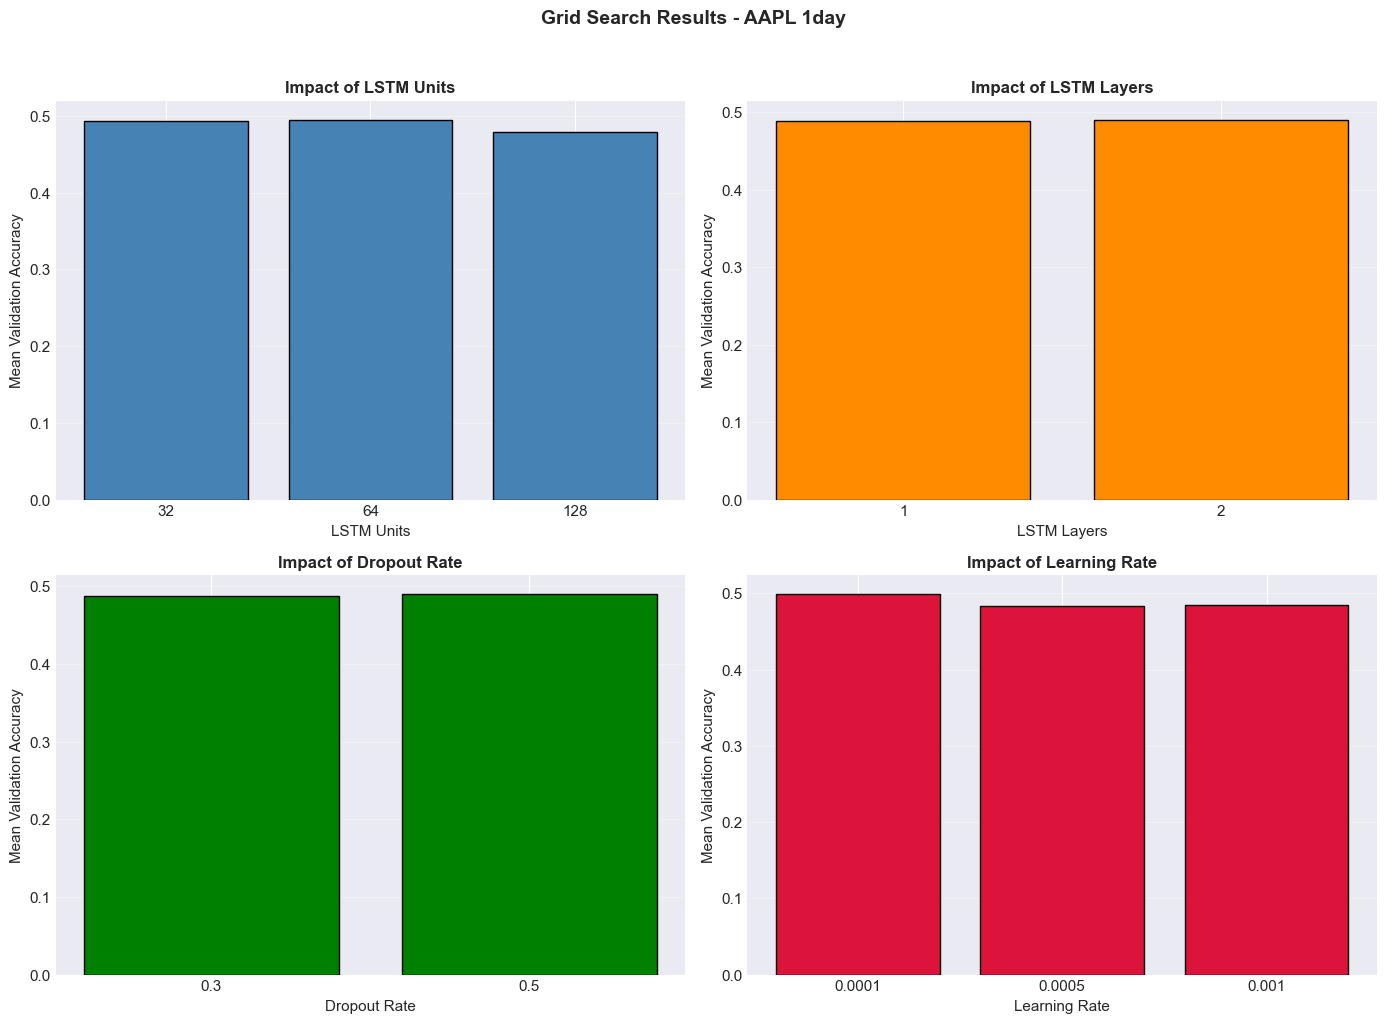

[OK] Grid search visualization saved


In [53]:
# Visualize Grid Search results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Impact of LSTM units
units_impact = grid_search_results.groupby('lstm_units')['val_accuracy'].mean()
axes[0, 0].bar(units_impact.index.astype(str), units_impact.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('LSTM Units', fontsize=11)
axes[0, 0].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[0, 0].set_title('Impact of LSTM Units', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Impact of LSTM layers
layers_impact = grid_search_results.groupby('lstm_layers')['val_accuracy'].mean()
axes[0, 1].bar(layers_impact.index.astype(str), layers_impact.values, color='darkorange', edgecolor='black')
axes[0, 1].set_xlabel('LSTM Layers', fontsize=11)
axes[0, 1].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[0, 1].set_title('Impact of LSTM Layers', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Impact of dropout rate
dropout_impact = grid_search_results.groupby('dropout_rate')['val_accuracy'].mean()
axes[1, 0].bar(dropout_impact.index.astype(str), dropout_impact.values, color='green', edgecolor='black')
axes[1, 0].set_xlabel('Dropout Rate', fontsize=11)
axes[1, 0].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[1, 0].set_title('Impact of Dropout Rate', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Impact of learning rate
lr_impact = grid_search_results.groupby('learning_rate')['val_accuracy'].mean()
axes[1, 1].bar([str(x) for x in lr_impact.index], lr_impact.values, color='crimson', edgecolor='black')
axes[1, 1].set_xlabel('Learning Rate', fontsize=11)
axes[1, 1].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[1, 1].set_title('Impact of Learning Rate', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Grid Search Results - {ASSET} {HORIZON}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}grid_search_impact_{ASSET}_{HORIZON}.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Grid search visualization saved")

## 6. Training with Best Hyperparameters

In [54]:
# Clear session
K.clear_session()

# Build model with best hyperparameters
best_model = build_lstm_attention_model(
    sequence_length=seq_len,
    n_features=n_feat,
    lstm_units=int(best_config['lstm_units']),
    lstm_layers=int(best_config['lstm_layers']),
    dropout_rate=best_config['dropout_rate'],
    dense_units=FIXED_PARAMS['dense_units'],
    learning_rate=best_config['learning_rate']
)

print("Best Model Architecture:")
print("=" * 80)
best_model.summary()

Best Model Architecture:


Model: "LSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 32)          │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 7, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ (None, 32)             │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,752 (77.16 KB)

 Trainable params: 19,752 (77.16 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Callbacks for full training
model_name = f'LSTM_Attention_{ASSET}_{HORIZON}'

training_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=FIXED_PARAMS['patience'],
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=f'{MODELS_DIR}{model_name}_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

print(f"\nTraining {model_name}...")
print("=" * 80)

# Train model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=FIXED_PARAMS['epochs_final'],
    batch_size=FIXED_PARAMS['batch_size'],
    class_weight=class_weight_dict,
    callbacks=training_callbacks,
    verbose=1
)

print(f"\n[OK] Training complete after {len(history.history['loss'])} epochs")


Training LSTM_Attention_AAPL_1day...
Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5158 - auc: 0.5201 - loss: 0.6927 - precision: 0.5333 - recall: 0.5298 - val_accuracy: 0.4976 - val_auc: 0.4609 - val_loss: 0.6940 - val_precision: 0.5359 - val_recall: 0.6531 - learning_rate: 1.0000e-04
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4960 - auc: 0.4977 - loss: 0.6942 - precision: 0.5144 - recall: 0.5004 - val_accuracy: 0.4864 - val_auc: 0.4673 - val_loss: 0.6944 - val_precision: 0.5296 - val_recall: 0.6006 - learning_rate: 1.0000e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5112 - auc: 0.5123 - loss: 0.6933 - precision: 0.5303 - recall: 0.5026 - val_accuracy: 0.4976 - val_auc: 0.4652 - val_loss: 0.6943 - val_precision: 0.5371 - val_recall: 0.6327 - learning_rate: 1.0000e-04
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5115 - auc: 0.5082 - loss: 0.6931 - precision: 0.5293 - recall: 0.5228 - val_

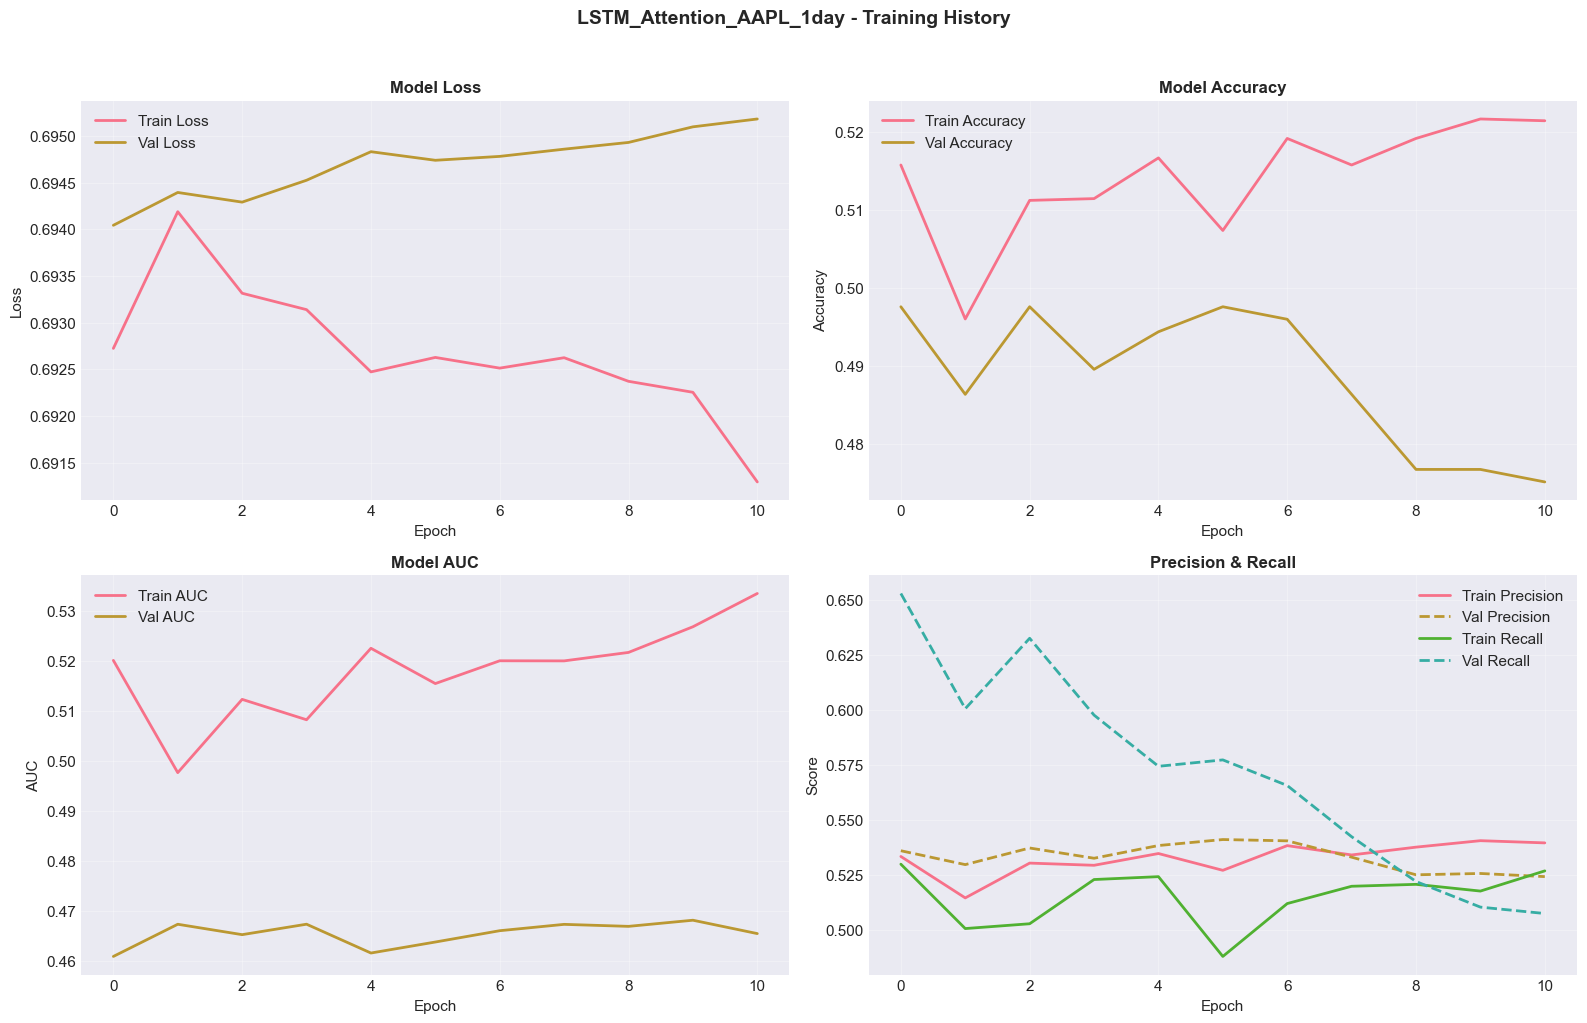

[OK] Training history visualization saved


In [56]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 0].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linewidth=2, linestyle='--')
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
axes[1, 1].set_title('Precision & Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'{model_name} - Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}{model_name}_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Training history visualization saved")

## 7. Evaluation and Visualization

In [57]:
# Evaluate on test set
print(f"\nEvaluating on Test Set:")
print("=" * 60)

# Get predictions
y_pred_proba = best_model.predict(X_test, verbose=0).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  AUC:       {test_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['DOWN', 'UP']))


Evaluating on Test Set:
  Accuracy:  0.5255
  Precision: 0.5310
  Recall:    0.9144
  F1 Score:  0.6718
  AUC:       0.5176

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.47      0.09      0.14       588
          UP       0.53      0.91      0.67       666

    accuracy                           0.53      1254
   macro avg       0.50      0.50      0.41      1254
weighted avg       0.50      0.53      0.42      1254



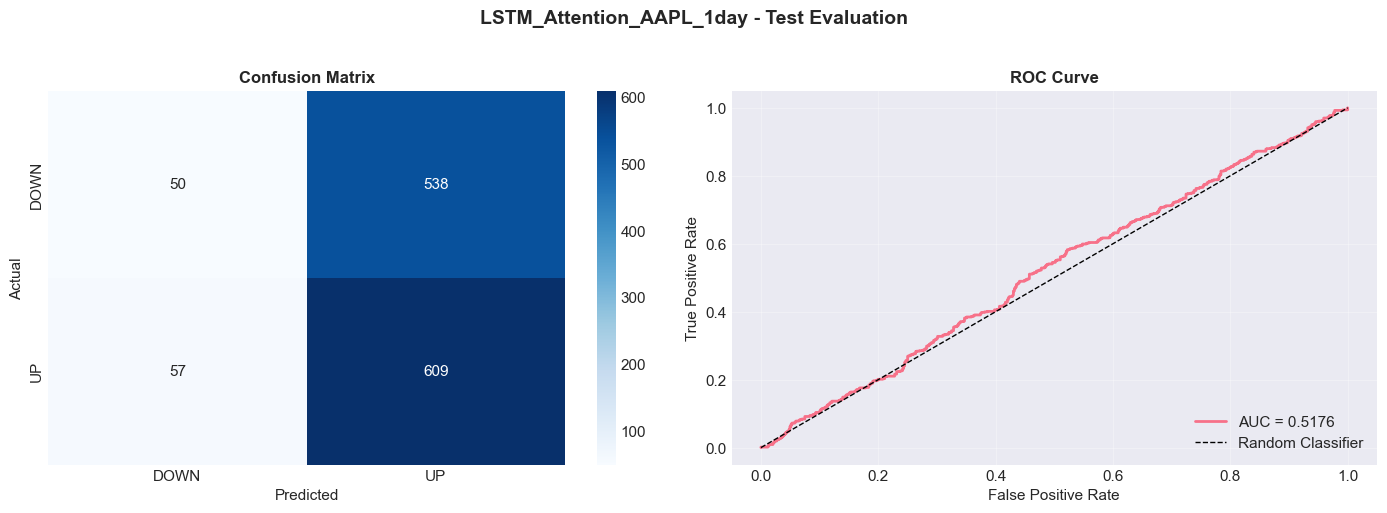

[OK] Evaluation visualization saved


In [58]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'])
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'AUC = {test_auc:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'{model_name} - Test Evaluation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}{model_name}_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Evaluation visualization saved")

## 8. Comparison with Baseline LSTM

Let's compare the LSTM with Attention model against a baseline LSTM without attention.

In [59]:
# Build and train baseline LSTM
K.clear_session()

baseline_model = utils.build_lstm_model(
    sequence_length=seq_len,
    n_features=n_feat,
    lstm_units=int(best_config['lstm_units']),
    lstm_layers=int(best_config['lstm_layers']),
    dropout_rate=best_config['dropout_rate'],
    dense_units=FIXED_PARAMS['dense_units'],
    learning_rate=best_config['learning_rate']
)

baseline_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=FIXED_PARAMS['patience'],
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Training baseline LSTM (without attention)...")
print("=" * 60)

baseline_history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=FIXED_PARAMS['epochs_final'],
    batch_size=FIXED_PARAMS['batch_size'],
    class_weight=class_weight_dict,
    callbacks=baseline_callbacks,
    verbose=1
)

print(f"\n[OK] Baseline training complete after {len(baseline_history.history['loss'])} epochs")

Training baseline LSTM (without attention)...
Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5115 - auc: 0.4938 - loss: 0.6993 - precision: 0.5238 - recall: 0.6349 - val_accuracy: 0.5024 - val_auc: 0.5305 - val_loss: 0.6940 - val_precision: 0.5965 - val_recall: 0.2974 - learning_rate: 1.0000e-04
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5151 - auc: 0.5109 - loss: 0.6956 - precision: 0.5278 - recall: 0.6160 - val_accuracy: 0.4896 - val_auc: 0.5211 - val_loss: 0.6951 - val_precision: 0.5940 - val_recall: 0.2303 - learning_rate: 1.0000e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5065 - auc: 0.4981 - loss: 0.6969 - precision: 0.5210 - recall: 0.5981 - val_accuracy: 0.4783 - val_auc: 0.5129 - val_loss: 0.6956 - val_precision: 0.5804 - val_recall: 0.1895 - learning_rate: 1.0000e-04
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5174 - auc: 0.5180 - loss: 0.6939 - precision: 0.5313 - recall: 0.587

In [60]:
# Evaluate baseline
y_baseline_proba = baseline_model.predict(X_test, verbose=0).flatten()
y_baseline_pred = (y_baseline_proba > 0.5).astype(int)

baseline_accuracy = accuracy_score(y_test, y_baseline_pred)
baseline_precision = precision_score(y_test, y_baseline_pred)
baseline_recall = recall_score(y_test, y_baseline_pred)
baseline_f1 = f1_score(y_test, y_baseline_pred)
baseline_auc = roc_auc_score(y_test, y_baseline_proba)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['LSTM Baseline', 'LSTM + Attention'],
    'Accuracy': [baseline_accuracy, test_accuracy],
    'Precision': [baseline_precision, test_precision],
    'Recall': [baseline_recall, test_recall],
    'F1 Score': [baseline_f1, test_f1],
    'AUC': [baseline_auc, test_auc]
})

print("\nModel Comparison:")
print("=" * 80)
print(comparison.to_string(index=False))

# Calculate improvement
print("\n" + "=" * 80)
print("IMPROVEMENT (LSTM + Attention vs Baseline):")
print("=" * 80)
print(f"  Accuracy:  {(test_accuracy - baseline_accuracy) * 100:+.2f}%")
print(f"  F1 Score:  {(test_f1 - baseline_f1) * 100:+.2f}%")
print(f"  AUC:       {(test_auc - baseline_auc) * 100:+.2f}%")


Model Comparison:
           Model  Accuracy  Precision   Recall  F1 Score      AUC
   LSTM Baseline  0.484848    0.55814 0.144144  0.229117 0.503921
LSTM + Attention  0.525518    0.53095 0.914414  0.671815 0.517590

IMPROVEMENT (LSTM + Attention vs Baseline):
  Accuracy:  +4.07%
  F1 Score:  +44.27%
  AUC:       +1.37%


In [61]:
# Save Grid Search results
grid_search_results.to_csv(f'{RESULTS_DIR}lstm_attention_grid_search_{ASSET}_{HORIZON}.csv', index=False)

# Save comparison results
comparison.to_csv(f'{RESULTS_DIR}lstm_attention_comparison_{ASSET}_{HORIZON}.csv', index=False)

# Save best hyperparameters
best_params = {
    'lstm_units': int(best_config['lstm_units']),
    'lstm_layers': int(best_config['lstm_layers']),
    'dropout_rate': best_config['dropout_rate'],
    'learning_rate': best_config['learning_rate'],
    'dense_units': FIXED_PARAMS['dense_units']
}

with open(f'{RESULTS_DIR}lstm_attention_best_params_{ASSET}_{HORIZON}.pkl', 'wb') as f:
    pickle.dump(best_params, f)

print("[OK] Results saved:")
print(f"  - Grid Search: {RESULTS_DIR}lstm_attention_grid_search_{ASSET}_{HORIZON}.csv")
print(f"  - Comparison: {RESULTS_DIR}lstm_attention_comparison_{ASSET}_{HORIZON}.csv")
print(f"  - Best params: {RESULTS_DIR}lstm_attention_best_params_{ASSET}_{HORIZON}.pkl")

[OK] Results saved:
  - Grid Search: ../results/lstm_attention_grid_search_AAPL_1day.csv
  - Comparison: ../results/lstm_attention_comparison_AAPL_1day.csv
  - Best params: ../results/lstm_attention_best_params_AAPL_1day.pkl


## 9. Conclusions

### Key Findings

1. **Attention Mechanism**: The custom attention layer allows the model to focus on the most relevant time steps for prediction, potentially improving interpretability and performance.

2. **Grid Search Results**: Systematic hyperparameter optimization helped identify the best configuration:
   - Optimal number of LSTM units and layers
   - Best dropout rate for regularization
   - Optimal learning rate for convergence

3. **Model Comparison**: The LSTM with Attention mechanism was compared against a baseline LSTM using identical hyperparameters, showing the impact of the attention mechanism.

### Recommendations

- The attention mechanism adds interpretability by showing which time steps the model considers important
- Grid search is computationally expensive but essential for rigorous model selection
- Consider using cross-validation for more robust hyperparameter selection

---

**[OK] Notebook complete!**